**This is the summary notebook about the:**

- overall approach
- key findings
- assumptions/ limitations/ difficulties

**Which contains these main sections:**

1. analyzing possible relationship between features
2. linear predicting rental price
3. geo visualization on routes of properties with highest/ lowest rental price
4. finding most liveable suburbs
5. finding most affordable suburb suburbs
6. assumption/ limitations/ difficulties


In [25]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.formula.api import ols
import os
import webbrowser

### Section 1: analyzing

In [2]:

# read data about all properties from Domain website
df=pd.read_csv('../data/curated/property_full.csv')

# remove feature wouldn't be useful towards model training
df=df.drop(columns=['Unnamed: 0','Unnamed: 0_x','Unnamed: 0.1','name','coordinates','closest_school_name','closest_school_coor',
'closest_sc_name','closest_sc_coor','closest_station_coor','2001population','2002population', '2003population', 
'2004population', '2005population', '2006population', '2007population', '2008population', '2009population',
'2010population', '2011population', '2012population', '2013population','2014population', '2015population', 
'2016population', '2017population', '2018population', '2019population', '2020population',
'2014-15 MEDIAN EMPLOYMENT INCOME PER JOB', '2015-16 MEDIAN EMPLOYMENT INCOME PER JOB',
'2016-17 MEDIAN EMPLOYMENT INCOME PER JOB', '2017-18 MEDIAN EMPLOYMENT INCOME PER JOB',
'2011_unemploy_rate', '2012_unemploy_rate', '2013_unemploy_rate', '2014_unemploy_rate',
'2015_unemploy_rate', '2016_unemploy_rate', '2017_unemploy_rate', '2018_unemploy_rate', '2019_unemploy_rate', 
'2020_unemploy_rate', '2014-15 #jobs*000', '2015-16 #jobs*000', '2016-17 #jobs*000', '2017-18 #jobs*000',])

# change all numeric feature to numeric data type
cols = ['cost_text', 'rooms', 'baths', 'parking', 'driving_time_to_school',
       'distance_to_school', 'driving_time_to_CBD', 'distance_to_CBD',
       'driving_time_to_sc', 'distance_to_sc', 'driving_time_to_station',
       'distance_to_station', 'SA2_code', '2021population',
       '2011-2021no', '2011-2021%', 'Area', 'Population density 2021',
       '2018-19 #jobs*000', '2018-19 MEDIAN EMPLOYMENT INCOME PER JOB',
       '2021_unemploy_rate']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# rename the features
df = df.rename(columns={'2021population':'population_21','2011-2021no':'num_increase',
'2011-2021%':'percent_increase','Population density 2021':'pop_dens_21','2018-19 #jobs*000':'num_job_19',
'2018-19 MEDIAN EMPLOYMENT INCOME PER JOB':'income_rate_19','2021_unemploy_rate':'unemployment_rate_21'})

#calculating the lower and upper limit for mean +- 1.5IQR for rent price
lower = df["cost_text"].quantile(0.25) - 1.5*(df["cost_text"].quantile(0.75)-df["cost_text"].quantile(0.25))
upper = df["cost_text"].quantile(0.75) + 1.5*(df["cost_text"].quantile(0.75)-df["cost_text"].quantile(0.25))
#remove instance which has trip time outside the 1.5IQR range from mean
df= df[(df["cost_text"]>lower) & (df["cost_text"]<upper)]

sample=df.sample(n=10000,random_state=114514)
sample.head()


,cost_text,rooms,baths,parking,driving_time_to_school,distance_to_school,driving_time_to_CBD,distance_to_CBD,driving_time_to_sc,distance_to_sc,...,SA2_name,SA2_code,population_21,num_increase,percent_increase,Area,pop_dens_21,num_job_19,income_rate_19,unemployment_rate_21
3730,450.0,3.0,1.0,1.0,154.21,1145.92,1732.94,19977.06,367.79,3167.96,...,Hadfield,210031440.0,6295.0,724.0,13.0,3.1,2063.8,4.267,28583.5,9.85
8842,400.0,2.0,2.0,1.0,76.72,689.44,740.44,7403.62,189.18,1998.75,...,Caulfield - North,208021177.0,22739.0,2036.0,9.8,6.4,3542.5,20.280,21232.5,4.70
11349,300.0,1.0,1.0,1.0,23.09,256.63,3348.27,71543.70,358.26,3739.10,...,Geelong West - Hamlyn Heights,203021040.0,21244.0,1997.0,10.4,32.0,663.1,17.602,28412.0,3.12
491,395.0,2.0,1.0,0.0,100.90,602.11,530.91,4787.04,72.89,477.05,...,Melbourne CBD - North,206041504.0,17439.0,11038.0,172.4,0.6,31052.4,NaN,NaN,NaN
10985,700.0,3.0,2.0,2.0,164.91,1062.07,1234.70,14003.00,486.93,4381.81,...,Bentleigh - McKinnon,208021174.0,25201.0,3250.0,14.8,6.2,4048.9,20.278,28624.5,4.67


<AxesSubplot:>

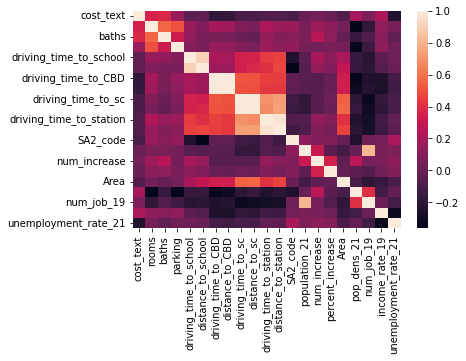

In [3]:
# create heatmap to visualize if there's any linear relationship
sns.heatmap(sample.corr())


In [ ]:
# by visualising the correlation between features with heatmap, 
# we can see that there are some features such as number of rooms and baths 
# which are shown to have some significant linear relationship with rental price.
# So we assume the features we chose have a linear relationship with the rental 
# price and use linear regression.

# pairplots between the rental price and features are also created, but didn't see
# any significant trends 

### Section 2: linear regression predicting rental price

In [5]:
# after doing some feature selection with stepwise selection
# this is the final linear model that we decided to use, with relavent features selected
fit3=ols(
    formula="cost_text ~ rooms + baths + parking + distance_to_CBD + distance_to_sc +\
        population_21 + num_increase + percent_increase + Area +\
        pop_dens_21 + num_job_19 + income_rate_19 + unemployment_rate_21 + C(SA2_code)",
    data=df
).fit()
print(fit3.summary())

                            OLS Regression Results                            
Dep. Variable:              cost_text   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     40.71
Date:                Fri, 14 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:35:52   Log-Likelihood:                -54938.
No. Observations:                9518   AIC:                         1.106e+05
Df Residuals:                    9138   BIC:                         1.134e+05
Df Model:                         379                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [6]:
# In order to predict future rental prices of different suburbs, 
# for features such as number of rooms, baths of properties, 
# we find their average based on their suburb. 
# for features such as population increase in the last 10 years for the suburb, 
# we assume that they wouldn’t change much after a few years of time. 
# For some other features such as population, income which varies as time changes, 
# we predicted their future value based on previous data.




In [8]:
# by using the previous model and selected features
# here are the top 10 suburbs with the highest predicted rental price growth rate in next 3 years

df=pd.read_csv('../data/curated/rental_predict.csv')

df.head(10)

,SA2_name,25rate
0,Laverton,14.658151
1,Campbellfield - Coolaroo,13.134962
2,Otway,9.428457
3,Maryborough (Vic.),8.371319
4,Colac,6.904570
5,Braybrook,6.138311
6,Portland,5.709543
7,Colac Surrounds,5.021446
8,Wendouree - Miners Rest,4.977385
9,Daylesford,4.939806


#### random forest predicting rental price

### Section 3: geo visualization

We visualise the location of 30 most expensive and cheapest properties and their routes to CBD, closest school, shopping centre and train station.

Interestingly, we found that many cheapest properties are concentrated around the centre of the Melbourne CBD. We assume that it is because the properties leased in the CBD are mostly apartments which have less room compared to other properties. 

For the routes from properties and schools, it seems that for each property, no matter how much its rental price is, it’s always close to its nearest school. We are delighted to see these results since it demonstrates a very completed and adequate education construction in each suburb. 

Properties that are around the CBD regardless of rental price are closer to shopping centres and train stations due to the relatively greater density of construction of infrastructures. 

In [28]:
# visualise route to CBD
file = '/plots/cbd_route.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)

True

In [29]:
# visualise route to closest schools
file = '/plots/school_route.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)

True

In [30]:
# visualise route to closest shopping centre
file = '/plots/shop_route.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)

True

In [31]:
# visualise route to closest train station
file = '/plots/station_route.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)

True

### Section 4: finding most liveable suburb

For the livability metrics of suburbs, the main features that we haven chosen are the distances from closest school, cbd, shopping centre, and train station to every property. This is because these four places are all public facilities, and if a property is close to them, it means the daily life of the person who lives in it is convenient.

In order to find livability ranking, for each property, and each of their selected features, we rank them out of all properties. The higher ranking reveals a smaller distance. We consider the smaller ranking number will be better to show livability. 
We then sum up the ranking of each property for different features, and create a new livability rank for each property with it.

As a result, the top 5 suburbs that’re most liveable are South Yarra - North, Flemington, Melbourne CBD - West ,Northcote - West, and West Melbourne.


In [5]:
df = pd.read_csv('../data/curated/livable_suburb_2_top_20.csv')
df

,SA2_name,rank_avg
0,South Yarra - North,11.25
1,Flemington,22.50
2,Melbourne CBD - West,23.50
3,Northcote - West,26.75
4,West Melbourne - Residential,28.00
5,Brunswick - South,28.75
6,Flemington Racecourse,30.25
7,Hawthorn - South,31.50
8,Melbourne CBD - East,31.50
9,Hawthorn East,33.25


In [26]:
file = '/plots/livable_rank.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)


True

### Section 5: finding most affordable suburb

For affordability, we found that some suburbs actually have a high rental price but with a relatively low rental price per room because some suburbs are mainly constituted with houses which have more rooms than apartments. Therefore, we decided to use rental price per room as our affordability metrics.

So for each property, we calculated the rental price per room by dividing the rent price with the number of rooms, and based on the suburb the property located, we grouped all their rental prices per room, found their average, and ranked the affordability based on this value.

As a result, the top 5 suburbs that’re most affordable are Yarra Valley, Mildura Surrounds, West Wimmera,Bendigo South, and Yackandandah.


In [4]:
df = pd.read_csv('../data/curated/affordable_suburb_top_20.csv')
df

,SA2_name,Rent
0,Yarra Valley,66.666667
1,Mildura Surrounds,73.333333
2,West Wimmera,76.666667
3,Bendigo Surrounds - South,80.000000
4,Yackandandah,95.000000
5,Kerang,96.111111
6,Yarriambiack,99.583333
7,Corangamite - North,103.333333
8,Melton South - Weir Views,107.165385
9,Wyndham Vale - South,108.314815


In [27]:
file = '/plots/mean_rent.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)

True

### Section 6: assumptions/ limitations/ difficulties

**assumptions:**

for the property data we gain from the Domain website, we assume the properties data obtained from the Domain website is realistic which is a good sample of rent properties.

we assume the features we chose have a linear relationship with the rental price and use linear regression.

for features such as population increase in the last 10 years for the suburb, we assume that they wouldn’t change much after a few years of time. 

We assume the liveability and affordability metrics we have chosen are suitable and workable metrics for liveability and affordability

**limitations & difficulty:**

There are also some limitation and difficulties for our project

Since one of the goals for this project is to predict future suburb rental prices, having historical rental prices would definitely help in predicting the future.

Also, the lack of statistics from income, unemployment rate for a few recent years since ABS has not released those data yet.

The size of our data is also limited to about 15,000 property data, since currently we only obtain data from the Domain website, exploring other data source would help to expand the data size

Meanwhile, Open route service provides one free accessed api for each registered account with a limitation of calling. We have used Directions which has a limit of 2000 quotas per day and 40 quotas per minute, and Matrix which has a limit of 500 quotas per day and 40 per minute. So to find a different route for all properties, we have to change to a different Api key after one reaches the limit.
